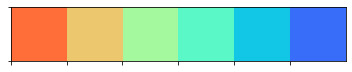

In [54]:
import os, warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

import tensorflow as tf
import gc
import tensorflow.keras.backend as K

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

import pandas as pd
from pandas import Series
import numpy as np
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import molmap.model

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette("rainbow_r", 6) #PiYG
sns.palplot(color)

from joblib import load, dump
import sklearn.metrics
import scipy
import logging

def r2_score(y_true,y_pred):
    y_mean = np.mean(y_true)
    r2 = 1-sum((y_true-y_pred)**2)/sum((y_mean-y_true)**2)
    return r2
def PCC(y_pred,y_true):
    diff_pred,diff_true=y_pred-np.mean(y_pred),y_true-np.mean(y_true)
    return np.sum(diff_pred*diff_true)/np.sqrt(np.sum(diff_pred**2)*np.sum(diff_true**2))

def from_ic50(ic50, max_ic50=50000.0):
    x = 1.0 - (np.log(np.maximum(ic50, 1e-12)) / np.log(max_ic50))
    return np.minimum(
        1.0,
        np.maximum(0.0, x))
def to_ic50(x, max_ic50=50000.0):
    return max_ic50 ** (1.0 - x)
sample_weight=None,
threshold_nm=500,
max_ic50=50000

读取 blosum62 matrix + pam250 matrix

In [55]:
blosum62 = pd.read_csv('/raid/hly/NEW METHOD EXPT/blosum&pam/data/BLOSUM62.txt', sep='\s')
blosum62 = blosum62.iloc[:-4,:-4]

pam250 = pd.read_csv('/raid/hly/NEW METHOD EXPT/blosum&pam/data/PAM250.csv',index_col=0)

将 blosum62 matrix 以及 pam250 mutation matrix 标准化到 0~1

In [56]:
# aapro归一化
PCP = pd.read_csv('/raid/hly/vaccin/data/cal_CTD/PCP_61.csv', index_col='properties').index
AApro_dic = pd.read_csv('/raid/hly/umap/single_index/AApro_UMAP.csv', header=0,index_col=0)
AA_pro = AApro_dic.loc[PCP].astype('float')
AA_pro = AA_pro.T
AA_pro = ((AA_pro - AA_pro.min()) / (AA_pro.max() - AA_pro.min())).T #归一化

序列相关 aapro,blosum62,pam250 距离矩阵的生成与拼接

In [57]:
def get_3d_feat(seq):
    n = len(seq)

    # 生成理化性质矩阵
    seq_pro = pd.DataFrame(AA_pro[aa] for aa in seq).T
    seq_pro = seq_pro.values[:, :, None]  #二维变成三维（61， n， 1）
    ## 相乘
    mt_pro = np.transpose((seq_pro * np.transpose(seq_pro, [0, 2, 1])), [1, 2, 0])  #**.5   #here!! **0.25
    ## transpose三维转置。（61，n，1）*（61，1，n）=（61，n，n），再转置成（n，n，61）.

    # 生成blosum矩阵
    seq_blosum = np.ones((n,n))
    for i in range(n):
        a = seq[i]
        for j in range(n):
            b = seq[j]
            seq_blosum[i][j] = blosum62.loc[a,b]
    seq_blosum_nor = ((seq_blosum - seq_blosum.min()) / (seq_blosum.max() - seq_blosum.min()))
    seq_blosum_nor = seq_blosum_nor[:, :, np.newaxis]  ##（n，n，1）

    # 生成pam矩阵
    seq_pam = np.ones((n,n))
    for i in range(n):
        a = seq[i]
        for j in range(n):
            b = seq[j]
            seq_pam[i][j] = pam250.loc[a,b]
    seq_pam_nor = ((seq_pam - seq_pam.min()) / (seq_pam.max() - seq_pam.min()))
    seq_pam_nor = seq_pam_nor[:, :, np.newaxis]  ##（n，n，1）

    # 生成序列距离矩阵
    pt_dis = np.ones((n,n))
    for i in range(n):
        for j in range(n):
            pt_dis[i][j] = abs(i-j)
    pt_dis = ((pt_dis - 0) / (n-1 - 0)) ## 归一化（最小值为0，最大值为n-1）
    pt_dis = pt_dis[:, :, np.newaxis]  ##（n，n，1）

    # 改变 理化性质矩阵 的下半部分
    for k in range(mt_pro.shape[2]):
        for i in range(n):
            for j in range(i):
                if k < 60:                                      ##here
                    mt_pro[i,j,k] = (mt_pro[j,i,k] * mt_pro[j,i,k+1])**.5
                else:
                    mt_pro[i,j,k] = (mt_pro[j,i,k] * mt_pro[j,i,0])**.5

    # 拼接矩阵
    mt = np.concatenate((pt_dis,seq_blosum_nor,seq_pam_nor,mt_pro),axis = 2)

    x = np.pad(mt, [(0, max_seq_len-n), (0, max_seq_len-n), (0, 0)]) #填充0.令数据集中每条序列对应的Xshape相同。

    return x[ :, :, :, None]

In [58]:
class Inception(tf.keras.layers.Layer):

    def __init__(self, units = 8, strides = 1):
        super(Inception, self).__init__()
        self.conv1 = tf.keras.layers.Conv3D(units, (1,1,1), padding='same', activation = 'relu', strides = strides,kernel_regularizer=tf.keras.regularizers.l2(lamda))
        self.conv2 = tf.keras.layers.Conv3D(units, (3,3,3), padding='same', activation = 'relu', strides = strides,kernel_regularizer=tf.keras.regularizers.l2(lamda))
        self.conv3 = tf.keras.layers.Conv3D(units, (5,5,5), padding='same', activation = 'relu', strides = strides,kernel_regularizer=tf.keras.regularizers.l2(lamda))
        self.concat = tf.keras.layers.Concatenate()

    def call(self, inputs):
        x1 = self.conv1(inputs)
        x2 = self.conv2(inputs)
        x3 = self.conv3(inputs)
        outputs = self.concat([x1, x2, x3])
        return outputs

    def get_config(self): 
        config = {"conv1": self.conv1,"conv2":self.conv2,'conv3':self.conv3}
        base_config = super(Inception, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [59]:
class Model_1(tf.keras.Model):
    def __init__(self):
            super().__init__()
            
            self.Cov_1 = tf.keras.layers.Conv3D(kn_1, ks_fir, activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda))
            self.MaxPool_1 = tf.keras.layers.MaxPool3D() #pool_size = (2,2,2)
    #         #here
    #         tf.keras.layers.Conv3D(kn_1, (5,5,5), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda),
    # bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda)),
    #         tf.keras.layers.MaxPool3D(), #pool_size = (2,2,2)
    #         #here
            self.Cov_2 =Inception(units=kn_2, strides=1)
            self.MaxPool_2 = tf.keras.layers.MaxPool3D()
            self.Cov_3 = Inception(units=kn_3, strides=1)
            self.GlobalMaxPool = tf.keras.layers.GlobalMaxPooling3D()         #tf.keras.layers.Flatten(),
            self.Dense_1 = tf.keras.layers.Dense(128, activation='relu')
            self.Dense_2 =tf.keras.layers.Dense(32, activation='relu')
            self.Dense_3 =tf.keras.layers.Dense(1)
    
    def call(self, input):
            x = self.Cov_1(input)
            x = self.MaxPool_1(x)
            x = self.Cov_2(x) 
            x = self.MaxPool_2(x)
            x = self.Cov_3(x)
            x = self.GlobalMaxPool(x)
            x = self.Dense_1(x)
            x = self.Dense_2(x)
            x = self.Dense_3(x)
            return x

In [60]:
class Model_2(tf.keras.Model):
    def __init__(self):
            super().__init__()
            
            self.Cov_1 = tf.keras.layers.Conv3D(kn_1, ks_fir, activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda))
            self.MaxPool_1 = tf.keras.layers.MaxPool3D() #pool_size = (2,2,2)
    #         #here
    #         tf.keras.layers.Conv3D(kn_1, (5,5,5), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda),
    # bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda)),
    #         tf.keras.layers.MaxPool3D(), #pool_size = (2,2,2)
    #         #here
            self.Cov_2 =Inception(units=kn_2, strides=1)
            self.MaxPool_2 = tf.keras.layers.MaxPool3D()
            self.Cov_3 = Inception(units=kn_3, strides=1)
            self.GlobalMaxPool = tf.keras.layers.GlobalMaxPooling3D()         #tf.keras.layers.Flatten(),
            self.Dense_1 = tf.keras.layers.Dense(512, activation='relu')
            self.Dense_2 =tf.keras.layers.Dense(64, activation='relu')
            self.Dense_3 =tf.keras.layers.Dense(1)
            
    
    def call(self, input):
            x = self.Cov_1(input)
            x = self.MaxPool_1(x)
            x = self.Cov_2(x) 
            x = self.MaxPool_2(x)
            x = self.Cov_3(x)
            x = self.GlobalMaxPool(x)
            x = self.Dense_1(x)
            x = self.Dense_2(x)
            x = self.Dense_3(x)
            return x

In [61]:
class Model_3(tf.keras.Model):
    def __init__(self):
            super().__init__()
            
            self.Cov_1 = tf.keras.layers.Conv3D(kn_1, ks_fir, activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda))
            self.MaxPool_1 = tf.keras.layers.MaxPool3D() #pool_size = (2,2,2)
    #         #here
    #         tf.keras.layers.Conv3D(kn_1, (5,5,5), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda),
    # bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda)),
    #         tf.keras.layers.MaxPool3D(), #pool_size = (2,2,2)
    #         #here
            self.Cov_2 =Inception(units=kn_2, strides=1)
            # self.MaxPool_2 = tf.keras.layers.MaxPool3D()
            # self.Cov_3 = Inception(units=kn_3, strides=1)
            self.GlobalMaxPool = tf.keras.layers.GlobalMaxPooling3D()         #tf.keras.layers.Flatten(),
            self.Dense_1 = tf.keras.layers.Dense(512, activation='relu')
            self.Dense_2 =tf.keras.layers.Dense(64, activation='relu')
            self.Dense_3 =tf.keras.layers.Dense(1)
            
    
    def call(self, input):
            x = self.Cov_1(input)
            x = self.MaxPool_1(x)
            x = self.Cov_2(x) 
            # x = self.MaxPool_2(x)
            # x = self.Cov_3(x)
            x = self.GlobalMaxPool(x)
            x = self.Dense_1(x)
            x = self.Dense_2(x)
            x = self.Dense_3(x)
            return x

In [62]:
class Model_4(tf.keras.Model):
    def __init__(self):
            super().__init__()
            
            self.Cov_1 = tf.keras.layers.Conv3D(kn_1, ks_fir, activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda))
            self.MaxPool_1 = tf.keras.layers.MaxPool3D() #pool_size = (2,2,2)
    #         #here
    #         tf.keras.layers.Conv3D(kn_1, (5,5,5), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda),
    # bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda)),
    #         tf.keras.layers.MaxPool3D(), #pool_size = (2,2,2)
    #         #here
            self.Cov_2 =Inception(units=kn_2, strides=1)
            # self.MaxPool_2 = tf.keras.layers.MaxPool3D()
            # self.Cov_3 = Inception(units=kn_3, strides=1)
            self.GlobalMaxPool = tf.keras.layers.GlobalMaxPooling3D()         #tf.keras.layers.Flatten(),
            self.Dense_1 = tf.keras.layers.Dense(128, activation='relu')
            self.Dense_2 =tf.keras.layers.Dense(32, activation='relu')
            self.Dense_3 =tf.keras.layers.Dense(1)
    
    def call(self, input):
            x = self.Cov_1(input)
            x = self.MaxPool_1(x)
            x = self.Cov_2(x) 
            # x = self.MaxPool_2(x)
            # x = self.Cov_3(x)
            x = self.GlobalMaxPool(x)
            x = self.Dense_1(x)
            x = self.Dense_2(x)
            x = self.Dense_3(x)
            return x

In [63]:
class Model_5(tf.keras.Model):
    def __init__(self):
            super().__init__()
            
            self.Cov_1 = tf.keras.layers.Conv3D(kn_1, ks_fir, activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda))
            self.MaxPool_1 = tf.keras.layers.MaxPool3D() #pool_size = (2,2,2)
            #here
            self.Cov_2 = tf.keras.layers.Conv3D(kn_1, (5,5,5), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda))
            self.MaxPool_2 = tf.keras.layers.MaxPool3D() #pool_size = (2,2,2)
            #here
            self.Cov_3 =Inception(units=kn_2, strides=1)
            self.MaxPool_3 = tf.keras.layers.MaxPool3D()
            self.Cov_4 = Inception(units=kn_3, strides=1)
            self.GlobalMaxPool = tf.keras.layers.GlobalMaxPooling3D()         #tf.keras.layers.Flatten(),
            self.Dense_1 = tf.keras.layers.Dense(128, activation='relu')
            self.Dense_2 =tf.keras.layers.Dense(32, activation='relu')
            self.Dense_3 =tf.keras.layers.Dense(1)
            
    
    def call(self, input):
            x = self.Cov_1(input)
            x = self.MaxPool_1(x)
            #here
            x = self.Cov_2(x)
            x = self.MaxPool_2(x)
            #here
            x = self.Cov_3(x) 
            x = self.MaxPool_3(x)
            x = self.Cov_4(x)
            x = self.GlobalMaxPool(x)
            x = self.Dense_1(x)
            x = self.Dense_2(x)
            x = self.Dense_3(x)
            return x

In [64]:
class Model_7(tf.keras.Model):
    def __init__(self):
            super().__init__()
            
            self.Cov_1 = tf.keras.layers.Conv3D(kn_1, ks_fir, activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda))
            self.MaxPool_1 = tf.keras.layers.MaxPool3D() #pool_size = (2,2,2)
    #         #here
    #         tf.keras.layers.Conv3D(kn_1, (5,5,5), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda),
    # bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda)),
    #         tf.keras.layers.MaxPool3D(), #pool_size = (2,2,2)
    #         #here
            self.Cov_2 =Inception(units=kn_2, strides=1)
            self.MaxPool_2 = tf.keras.layers.MaxPool3D()
            self.Cov_3 = Inception(units=kn_3, strides=1)
            self.GlobalMaxPool = tf.keras.layers.GlobalMaxPooling3D()         #tf.keras.layers.Flatten(),
            self.Dense_1 = tf.keras.layers.Dense(64, activation='relu')
            self.Dense_2 =tf.keras.layers.Dense(16, activation='relu')
            self.Dense_3 =tf.keras.layers.Dense(1)
    
    def call(self, input):
            x = self.Cov_1(input)
            x = self.MaxPool_1(x)
            x = self.Cov_2(x) 
            x = self.MaxPool_2(x)
            x = self.Cov_3(x)
            x = self.GlobalMaxPool(x)
            x = self.Dense_1(x)
            x = self.Dense_2(x)
            x = self.Dense_3(x)
            return x

In [65]:

new_data_test_dir = '/raid/hly/PK-3[2018PLOS]/new_arraylist_task/test_set/data/2021' #2021
# new_data_test_dir = '/raid/hly/PK-3[2018PLOS]/new_arraylist_task/test_set/data/2023' 

for file in os.listdir(new_data_test_dir):
    if os.path.exists(os.path.join(new_data_test_dir,file)) :

    ## 分别处理训练数据和测试数据，以便能求差值
        df_test = pd.read_csv(os.path.join(new_data_test_dir,file))
        df_test.rename(
                columns={"Description": "peptide", "Quantitative measurement": "measurement_value", "Normalized_QM": "Normalized_QM"},
                inplace=True)
        # 数据标准化 
        # df_test["Normalized_QM"] = df_test["measurement_value"].apply(from_ic50)
        # 保存文件
        df_test.to_csv(os.path.join(new_data_test_dir, file),index=0)

In [66]:
test_dir = '/raid/hly/PK-3[2018PLOS]/new_arraylist_task/test_set/data/2021'
# test_dir = '/raid/hly/PK-3[2018PLOS]/new_arraylist_task/test_set/data/2023'

for file in os.listdir(test_dir):

    Allele = file.split('.')[0]
    df_test = pd.read_csv(os.path.join(test_dir,Allele+'.csv'))
    max_seq_len = df_test['peptide'].apply(len).max()
    df_test.to_csv(os.path.join(test_dir,Allele+'.csv'))

    # 生成 X_test + Y_test 
    X_dir= '/raid/hly/PK-3[2018PLOS]/new_arraylist_task/test_set/test_X_data'
    X_test_name = os.path.join(X_dir,Allele+'_X_test'+'.data')
    if not os.path.exists(X_test_name) :
        X_test = []
        for seq in df_test['peptide']:
            X_test.append(get_3d_feat(seq))
        X_test = np.stack(X_test)
        dump(X_test, X_test_name)
    else:
        X_test = load(X_test_name)
    X_test = X_test.astype('float32') 

    # 载入模型和参数
    Allele_res_fold = '/raid/hly/PK-3[2018PLOS]/train_by_no-ms(test_in_train)/Res'+'/'+ Allele
    model_dir = os.path.join(Allele_res_fold,'models')
    df_res = pd.read_csv('/raid/hly/PK-3[2018PLOS]/train_by_no-ms(test_in_train)/pred_true/results_noMS_1.csv',index_col=0)
    #上述csv文件HLA-a0101 model为空 手动补入了model1
    # hla-a2402 model1会报错 手动改成了model2

    # 參數
    lr = df_res['lr'][Allele]
    ks_fir = df_res['kernel_size_1'][Allele]
    ks_fir = eval(ks_fir)
    kn = df_res['kernel_number'][Allele]
    kn = eval(kn)
    kn_1,kn_2,kn_3 = kn[0],kn[1],kn[2]
    lamda = df_res['lamda'][Allele]
    md = df_res['model'][Allele]

    model_index = md.split('_')[1]
    model = eval('Model_' + model_index+'()')

    X = load(X_test_name)
    model.build(X.shape)
    model.load_weights(os.path.join(model_dir,Allele+'_noMS_model_.h5'))

    print(
    Allele,
    'lr=',lr,
    'ks_fir=',ks_fir,
    'kn=',kn,
    'lamda=',lamda,
    'model=',md
    )

    # 做出预测
    test_predtrue_dir = '/raid/hly/PK-3[2018PLOS]/new_arraylist_task/test_set/test_predtrue/split_by_Allele'
    Y_pred = model.predict(X_test)
    df_pred = pd.DataFrame(Y_pred).rename(columns={0:'Pred_Norm_QM_Dopaap(nM)'})

    df_truepred = pd.merge(df_test,df_pred,how='inner',left_index=True,right_index=True)
    df_truepred['Pred_QM_Dopaap(nM)'] = df_truepred['Pred_Norm_QM_Dopaap(nM)'].apply(to_ic50)

    df_truepred.to_csv(os.path.join(test_predtrue_dir, Allele+'_prediction.csv'),index=0)

HLA-B_5101 lr= 0.0001 ks_fir= (3, 3, 7) kn= (48, 32, 64) lamda= 0.001 model= Model_1 


HLA-A_0101 lr= 0.0001 ks_fir= (9, 9, 13) kn= (48, 32, 64) lamda= 0.001 model= Model_1 
HLA-A_0201 lr= 0.0001 ks_fir= (9, 9, 13) kn= (48, 32, 64) lamda= 1e-06 model= Model_5
HLA-A_3301 lr= 0.0001 ks_fir= (3, 3, 7) kn= (48, 32, 64) lamda= 1e-09 model= Model_5
HLA-B_0801 lr= 0.0001 ks_fir= (9, 9, 13) kn= (48, 32, 64) lamda= 1e-09 model= Model_1 
HLA-A_6801 lr= 0.0001 ks_fir= (3, 3, 7) kn= (48, 32, 64) lamda= 1e-09 model= Model_1 
HLA-A_3001 lr= 0.0001 ks_fir= (3, 3, 27) kn= (48, 32, 64) lamda= 1e-06 model= Model_3 
HLA-B_4403 lr= 0.0001 ks_fir= (9, 9, 13) kn= (48, 32, 64) lamda= 0.001 model= Model_1 
HLA-A_1101 lr= 0.0001 ks_fir= (9, 9, 13) kn= (48, 32, 64) lamda= 1e-09 model= Model_1 
HLA-B_0702 lr= 0.0001 ks_fir= (3, 3, 7) kn= (48, 32, 64) lamda= 1e-09 model= Model_1 
HLA-A_3101 lr= 0.0001 ks_fir= (3, 3, 7) kn= (48, 32, 64) lamda= 1e-09 model= Model_1 
HLA-A_2402 lr= 0.0001 ks_fir= (3, 3, 7) kn= (24, 16, 32) lamda= 1e-05 model= Model_2  
HLA-A_0301 lr= 0.0001 ks_fir= (3, 3, 27) kn= (48,

In [67]:
pred_dir = '/raid/hly/PK-3[2018PLOS]/new_arraylist_task/test_set/test_predtrue/split_by_Allele'
df_allpred = pd.DataFrame()
for file in os.listdir(pred_dir):
    Allele = file.split('_')[0] + '_' + file.split('_')[1]
    pred_file = pd.read_csv(os.path.join(pred_dir,file),index_col=0)
    pred_file['Allele'] = Allele 
    df_allpred = df_allpred.append(pred_file)
    # df_allpred['Pred_Norm_QM_NetMHCpan4.0(nM)'] = df_allpred['Pred_QM_NetMHCpan4.0(nM)'].apply(from_ic50)
df_allpred.to_csv('/raid/hly/PK-3[2018PLOS]/new_arraylist_task/test_set/test_predtrue/test_predtrue.csv',index=0)

In [68]:
df_allpred = pd.read_csv('/raid/hly/PK-3[2018PLOS]/new_arraylist_task/test_set/test_predtrue/test_predtrue.csv')
df_allpred.head()

,Allele,Allele Name,Assay Group,Host Name,MHC allele class,Measurement Inequality,Normalized_QM,Pred_Norm_QM_Dopaap(nM),Pred_QM_Dopaap(nM),Qualitative Measure,...,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,measurement_value,peptide
0,HLA-A_1101,HLA-A*11:01,half maximal inhibitory concentration (IC50),Homo sapiens (human),I,=,0.110472,0.213918,4940.533475,Negative,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15131.0,EKVKIPVAIKT
1,HLA-A_1101,HLA-A*11:01,half maximal inhibitory concentration (IC50),Homo sapiens (human),I,=,0.146594,0.438358,435.652981,Negative,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10236.0,KVKIPVAIKT
2,HLA-A_1101,HLA-A*11:01,half maximal inhibitory concentration (IC50),Homo sapiens (human),I,=,0.136599,0.467852,316.627701,Negative,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11405.0,KVKIPVAIKTS
3,HLA-A_1101,HLA-A*11:01,half maximal inhibitory concentration (IC50),Homo sapiens (human),I,=,0.375287,0.488923,252.079095,Positive-Intermediate,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,862.0,KIPVAIKTSPK
4,HLA-A_1101,HLA-A*11:01,half maximal inhibitory concentration (IC50),Homo sapiens (human),I,=,0.249798,0.267468,2767.879188,Positive-Intermediate,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3351.0,IPVAIKTSPK


In [69]:
y_OD = df_allpred['Normalized_QM'].to_list()
y_pred_D = df_allpred['Pred_Norm_QM_Dopaap(nM)'].to_list()
# y_pred_N = df_allpred['Pred_QM_NetMHCpan4.0(nM)'].to_list()

In [70]:
# 计算R2
from sklearn.metrics import r2_score
import pandas as pd
r2_D = r2_score(y_OD, y_pred_D)
# r2_N = r2_score(y_OD, y_pred_N)
# print('r2_Dopaap = ',r2_D,'r2_NetMHCpan4.0 = ',r2_N)
print('r2_Dopaap = ',r2_D)


r2_Dopaap =  -0.7424737654575471


In [71]:
# 计算 Pearson r
def PCC(y_pred,y_true):
    diff_pred,diff_true=y_pred-np.mean(y_pred),y_true-np.mean(y_true)
    return np.sum(diff_pred*diff_true)/np.sqrt(np.sum(diff_pred**2)*np.sum(diff_true**2))
PCC_D = PCC(y_OD, y_pred_D)
# PCC_N = PCC(y_OD, y_pred_N)
# print('PCC_Dopaap = ',PCC_D,'PCC_NetMHCpan4.0 = ',PCC_N)
print('PCC_Dopaap = ',PCC_D)


PCC_Dopaap =  0.025752582201010035


In [72]:
# 计算 tau
import scipy.stats
tau_D = scipy.stats.kendalltau(y_pred_D, y_OD)[0]
# tau_N = scipy.stats.kendalltau(y_pred_N, y_OD)[0]
# print('tau_Dopaap = ',tau_D,'tau_NetMHCpan4.0 = ',tau_N)
print('tau_Dopaap = ',tau_D)



tau_Dopaap =  0.03200470451039323


In [73]:
pred_dir = '/raid/hly/PK-3[2018PLOS]/new_arraylist_task/test_set/test_predtrue/split_by_Allele'
df_allpred = pd.DataFrame()
for file in os.listdir(pred_dir):
    Allele = file.split('_')[0] + '_' + file.split('_')[1]
    pred_file = pd.read_csv(os.path.join(pred_dir,file),index_col=0)
    y_OD = pred_file['Normalized_QM'].to_list()
    y_pred_D = pred_file['Pred_Norm_QM_Dopaap(nM)'].to_list()
    r2_D = r2_score(y_OD, y_pred_D)
    PCC_D = PCC(y_OD, y_pred_D)
    tau_D = scipy.stats.kendalltau(y_pred_D, y_OD)[0]
    print(Allele,'r2=',r2_D,'pcc=',PCC_D,'tau=',tau_D)

HLA-A_1101 r2= 0.14458370985016133 pcc= 0.3807916461702569 tau= 0.23717372622892466
HLA-A_3301 r2= 0.5502530503568015 pcc= 0.9488069153984072 tau= 0.3333333333333334
HLA-B_0702 r2= 0.35379449285369013 pcc= 0.6380353819364589 tau= 0.41963015647226176
HLA-B_4403 r2= 0.10688001470087016 pcc= 0.8021115542953648 tau= 0.6666666666666666
HLA-A_3001 r2= -0.022414823151181373 pcc= 0.6718245639405646 tau= 0.4666666666666666
HLA-B_1501 r2= 0.04895812832714397 pcc= 0.23610296026061198 tau= 0.18947368421052632
HLA-A_0101 r2= 0.02990876349863103 pcc= 0.48713195856079256 tau= 0.27627627627627627
HLA-A_6801 r2= 0.15603191085645918 pcc= 0.8969701558923581 tau= 1.0
HLA-B_2705 r2= -1.6713575248525703 pcc= 0.7308653044731669 tau= 0.5061613648217599
HLA-B_5101 r2= 0.14088245141151867 pcc= 0.7027947434225413 tau= 0.5238095238095238
HLA-A_0201 r2= -2.1798652667185774 pcc= 0.1066384212985865 tau= 0.12597460951620484
HLA-B_0801 r2= -2.164339112705132 pcc= 0.36059614689857383 tau= 0.2771739468734333
HLA-A_0301 

训练模型

In [12]:
class_name = 'class_1'                                                     #here!
# Train_dir = '/raid/hly/PK-3[2018PLOS]/data/train_data-MID/'+ class_name +'_pre'     
Train_dir = '/raid/hly/PK-3[2018PLOS]/data/trainval_MID.no_MS(for_PK3)'
Test_dir = '/raid/hly/PK-3[2018PLOS]/data/PK-3_benchmark_data'

for file in os.listdir(Train_dir):

    Allele = file.split('.')[0]
    df_trainval = pd.read_csv(os.path.join(Train_dir,file))
    df_test = pd.read_csv(os.path.join(Test_dir,file))  
    
    # 创建储存 Allele 结果的文件夹
    task_dir = '/raid/hly/PK-3[2018PLOS]/Res_V1'             
    Allele_fold = os.path.join(task_dir,Allele)

    if not os.path.exists(Allele_fold) : 
        os.makedirs(Allele_fold)
        os.makedirs(os.path.join(Allele_fold,'loss'))
        os.makedirs(os.path.join(Allele_fold,'models'))
        os.makedirs(os.path.join(Allele_fold,'results'))

    # 获得训练集和测试集的最大序列长度
    train_max_seq_len = df_trainval['peptide'].apply(len).max()
    test_max_seq_len = df_test['peptide'].apply(len).max()
    max_seq_len = max(train_max_seq_len,test_max_seq_len)

    # 划分训练集与验证集
    kf = StratifiedKFold(
        n_splits= 10,  
        shuffle=True,
        random_state= 2)
 
    ### 使用 MHCflurry数据时的划分方式
    # Stratify by both allele and binder vs. nonbinder.
    df_trainval["key"] = [
        "%s_%s" % (
            row.allele,
            "binder" if row.measurement_value <= 500 else "nonbinder")
        for (_, row) in df_trainval.iterrows()
    ]
    
    (train_idx, valid_idx) = next(kf.split(df_trainval, df_trainval.key))
    df_train = df_trainval.iloc[train_idx]
    df_valid = df_trainval.iloc[valid_idx]
    ###  使用 MHCflurry数据时的划分方式

    # 生成 X_train + Y_train 
    X_train_name = os.path.join(Allele_fold, Allele+'_X_train_'+'.data')
    if not os.path.exists(X_train_name) :
        X_train = []
        for seq in df_train['peptide']:
            X_train.append(get_3d_feat(seq))
        X_train = np.stack(X_train)
        dump(X_train, X_train_name)
    else:
        X_train = load(X_train_name)
    X_train = X_train.astype('float32')
    Y_train = df_train['Normalized_QM'].values.reshape(-1, 1) 

    # 生成 X_valid + Y_valid
    X_valid_name = os.path.join(Allele_fold, Allele+'_X_valid_'+'.data')
    if not os.path.exists(X_valid_name) :
        X_valid= []
        for seq in df_valid['peptide']:
            X_valid.append(get_3d_feat(seq))
        X_valid = np.stack(X_valid)
        dump(X_valid, X_valid_name)
    else:
        X_valid = load(X_valid_name)
    X_valid = X_valid.astype('float32')
    Y_valid = df_valid['Normalized_QM'].values.reshape(-1, 1)     
   
   # 生成 X_test + Y_test 
    X_test_name = os.path.join(Allele_fold, Allele+'_X_test_'+'.data')
    if not os.path.exists(X_test_name) :
        X_test = []
        for seq in df_test['peptide']:
            X_test.append(get_3d_feat(seq))
        X_test = np.stack(X_test)
        dump(X_test, X_test_name)
    else:
        X_test = load(X_test_name)
    X_test = X_test.astype('float32')
    Y_test = df_test['Normalized_QM'].values.reshape(-1, 1) 

    # 确定参数
    ## 公共参数
    inc = (1,3,5)
    bs = 32
    
    ks_fir_ls = [(3,3,7),(3,3,27)] #(3,3,7),(3,3,17),(3,3,27),(5,5,9),(5,5,21),(9,9,13)
    kn_ls = [(24,16,32),(48,32,64)] 
    lamda_ls = [1e-3,1e-7] 
    lr_ls = [1e-4] #5e-5,

    # ## 先使用之前的参数
    # df_res = pd.read_csv('/raid/hly/vaccin/task/PK-3[2018PLOS]_Use IEDB Data/no_spec_mass/pred_true/results_noMS_1.csv',index_col=0)

    # ks_fir = df_res['kernel_size_1'][Allele]
    # ks_fir = eval(ks_fir)
    # kn = df_res['kernel_number'][Allele]
    # kn = eval(kn)
    # kn_1,kn_2,kn_3 = kn[0],kn[1],kn[2]
    # lamda = df_res['lamda'][Allele]
    # md = df_res['model'][Allele]
    #******************************************
    task_name = Allele +'_V1'

    for ks_fir in ks_fir_ls:
        for kn in kn_ls:
            kn_1,kn_2,kn_3 = kn[0],kn[1],kn[2]
            for lamda in lamda_ls:
                for lr in lr_ls:
                    model_ls = [Model_1(),Model_2(),Model_3(),Model_4(),Model_5(),Model_7()]
                    md_ls = ['Model_1','Model_2','Model_3','Model_4','Model_5','Model_7']     
                    for m in range(6):
                        md = md_ls[m]
                        model = model_ls[m]
                    
                        # continue 情况
                        df_done = pd.read_csv(os.path.join(task_dir,'done_list.csv'))
                        exists_name = task_name + '_(lr_%s-bs_%s-lam_%s-ks_[%s,%s]-kn_%s-md_%s)_' %(lr,bs,lamda,ks_fir,inc,kn,md)
                        if (exists_name +'_results.csv') in (df_done['done_file'].values):
                            continue

                        # 查看目前最佳 R2
                        result_file = os.path.join(Allele_fold,'results')
                        result_csv = result_file + '/' + task_name + '_results.csv'
                        if os.path.exists(result_csv) :
                            df_exit_res = pd.read_csv(result_csv)
                            best_exit_r2 = df_exit_res['test_r2'][0]
                        else:
                            best_exit_r2 = -1000

                        for n in range(1):
                    
                            print(exists_name)  
                            lr = lr
                            patience = 50
                            epochs = 300
                            loss= tf.keras.losses.log_cosh     #weighted_loss #tf.keras.losses.mean_squared_error 
                            batch_size = bs

                            df_loss = pd.DataFrame()          
                            results = []

                            opt = tf.keras.optimizers.Adam(lr=lr)
                            model.compile(optimizer=opt, loss=loss)

                            performance = molmap.model.cbks.Reg3D_EarlyStoppingAndPerformance((X_train, Y_train), 
                                                                            (X_valid, Y_valid), 
                                                                        patience = patience,
                                                                        )

                            model.fit(X_train, Y_train, batch_size=batch_size, 
                                    epochs = epochs, verbose = 0, shuffle = True, 
                                    validation_data = (X_valid, Y_valid), callbacks = [performance]) 
                        
                            best_epoch = performance.best_epoch
                            trainable_params = model.count_params()

                            #获取RMSE和R2
                            train_rmse,train_mae,train_r,train_r2,train_tau = performance.evaluate(X_train, Y_train)            
                            valid_rmse,valid_mae,valid_r,valid_r2,valid_tau = performance.evaluate(X_valid, Y_valid)

                            # make prediction
                            Y_test_pred = model.predict(X_test)
                            df_pred = pd.DataFrame(Y_test_pred.tolist()).rename(columns={0:'Pred_Norm_QM'})
                            df_pred['Pred_QM'] = df_pred['Pred_Norm_QM'].apply(to_ic50)
                            df_truepred = pd.merge(df_test,df_pred,how='inner',left_index=True,right_index=True)   

                            y_true = df_truepred['Normalized_QM']
                            y_pred = df_truepred['Pred_Norm_QM']
                            test_r2 = r2_score(y_true, y_pred)   
                            test_r = PCC(y_true, y_pred)           
            
                            if test_r2 >= best_exit_r2 :

                                #储存loss
                                dfl = pd.DataFrame(performance.history)
                                df_loss = df_loss.append(dfl, ignore_index = True)
                                df_loss.to_csv(os.path.join(os.path.join(Allele_fold,'loss'),  task_name +'_loss.csv'))
                            
                                # 储存 prediction
                                df_truepred.to_csv(os.path.join(Allele_fold,Allele+'true_pred.csv'))

                                # 计算 tau, auc, f1
                                test_tau = scipy.stats.kendalltau(y_pred, y_true)[0]

                                y_pred_score = from_ic50(y_pred, max_ic50)
                                try:
                                    test_auc = sklearn.metrics.roc_auc_score(
                                                y_true <= threshold_nm,
                                                y_pred_score,
                                                sample_weight=sample_weight)
                                except ValueError as e:
                                    logging.warning(e)
                                    test_auc = np.nan
                                
                                try:
                                    test_f1 = sklearn.metrics.f1_score(
                                                y_true <= threshold_nm,
                                                y_pred <= threshold_nm,
                                                sample_weight=sample_weight)
                                except ValueError as e:
                                    logging.warning(e)
                                    test_f1 = np.nan

                                #整体性结果
                                final_res = {
                                            'train_rmse':np.nanmean(train_rmse), 
                                            'valid_rmse':np.nanmean(valid_rmse),  
                                            # 'train_mse':np.nanmean(train_mse), 
                                            # 'valid_mse':np.nanmean(test_mse),                      
                                            'train_r2':np.nanmean(train_r2), 
                                            'valid_r2':np.nanmean(valid_r2), 
                                            'train_mae':np.nanmean(train_mae), 
                                            'valid_mae':np.nanmean(valid_mae),
                                            'train_r':np.nanmean(train_r), 
                                            'valid_r':np.nanmean(valid_r),
                                            'train_tau':np.nanmean(train_tau), 
                                            'valid_tau':np.nanmean(valid_tau),
                                            # 'train_auc':np.nanmean(train_auc), 
                                            # 'valid_auc':np.nanmean(valid_auc),
                                            'test_r2':np.nanmean(test_r2),
                                            'test_r':np.nanmean(test_r),
                                            'test_tau':np.nanmean(test_tau),
                                            'test_auc':np.nanmean(test_auc),
                                            'test_f1' : np.nanmean(test_f1),
                                            'trainable params': trainable_params, 
                                            'best_epoch': best_epoch,
                                            'lr' : lr,
                                            'batch_size':bs,
                                            'kernel_size_1':ks_fir,
                                            'kernel_size_incept': inc,
                                            'kernel_number':kn,
                                            'lamda' : lamda,
                                            'model' : md
                                            }

                                results.append(final_res)
                                dfr = pd.DataFrame(results)
                                dfr.to_csv(os.path.join(os.path.join(Allele_fold,'results'),  task_name +'_results.csv'))
                                
                                # 保存模型
                                model.save_weights(os.path.join(os.path.join(Allele_fold,'models'),  task_name +'_model_'+'.h5'))
                                
                                # 删除model
                                del model

                            print('*******************************************************')
                
                            df_done = pd.read_csv(os.path.join(task_dir,'done_list.csv'))  
                            new_donels = df_done['done_file'].append(pd.Series(exists_name +'_results.csv'))
                            df_newdone = pd.DataFrame(new_donels,columns=['done_file'])
                            df_newdone.to_csv(os.path.join(task_dir,'done_list.csv'))
    
    
    # # 删除缓存
    # del performance
    gc.collect()
    K.clear_session()
    tf.compat.v1.reset_default_graph() # TF graph isn't same as Keras grap



 epoch: 0072, loss: 0.0052 - val_loss: 0.0184; rmse: 0.0598 - rmse_val: 0.1735;  r2: 0.9480 - r2_val: 0.5554; mae: 0.0441 - mae_val: 0.1193; r: 0.9873 - r_val: 0.7674;tau: 0.8417 - tau_val: 0.5834                                                                                                    
 epoch: 0073, loss: 0.0053 - val_loss: 0.0170; rmse: 0.0451 - rmse_val: 0.1651;  r2: 0.9704 - r2_val: 0.5973; mae: 0.0324 - mae_val: 0.1156; r: 0.9853 - r_val: 0.7814;tau: 0.8311 - tau_val: 0.5935                                                                                                    
 epoch: 0074, loss: 0.0051 - val_loss: 0.0172; rmse: 0.0439 - rmse_val: 0.1666;  r2: 0.9719 - r2_val: 0.5900; mae: 0.0319 - mae_val: 0.1174; r: 0.9871 - r_val: 0.7766;tau: 0.8386 - tau_val: 0.5880                                                                                                    
 epoch: 0075, loss: 0.0050 - val_loss: 0.0178; rmse: 0.0498 - rmse_val: 0.1709;  r2: 0.9639 - r2_val: 0.5686;

*******************************************************
HLA-A_0301_V1_(lr_0.0001-bs_32-lam_0.001-ks_[(3, 3, 27),(1, 3, 5)]-kn_(48, 32, 64)-md_Model_3)_
 epoch: 0001, loss: 0.1293 - val_loss: 0.1052; rmse: 0.2330 - rmse_val: 0.2368;  r2: 0.2089 - r2_val: 0.1713; mae: 0.1815 - mae_val: 0.1867; r: 0.6050 - r_val: 0.5640;tau: 0.4535 - tau_val: 0.4217                                                                                                    
 epoch: 0002, loss: 0.0877 - val_loss: 0.0766; rmse: 0.1933 - rmse_val: 0.2023;  r2: 0.4551 - r2_val: 0.3956; mae: 0.1440 - mae_val: 0.1513; r: 0.6851 - r_val: 0.6405;tau: 0.5170 - tau_val: 0.4824                                                                                                    
 epoch: 0003, loss: 0.0681 - val_loss: 0.0626; rmse: 0.1819 - rmse_val: 0.1926;  r2: 0.5177 - r2_val: 0.4517; mae: 0.1381 - mae_val: 0.1460; r: 0.7258 - r_val: 0.6736;tau: 0.5475 - tau_val: 0.5083                                                          

In [13]:
Allele

'HLA-B_5301'